# Ames Housing Regression Analysis

The Ames housing dataset is an alternative to the Boston housing dataset for experimenting with tabular data. The associated kaggle competiiton (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) allows users to submit their predictions for a given test set, which is then scored by Kaggle in order to rank users on the leaderboard. 

## Contents
This notebook is roughly split into sections including:
- Loading the required modules, data and setting formatting options
- A brief exploration of the dataset and normalisation of the predicted variable for the test set (SalePrice)
- Imputation of missing values
- Visualisation and feature engineering
- Modelling and final prediction

## Loading Data and Modules
The modules numpy and pandas will be used to manipulate the tabular data from the Ames Housing dataset. Seaborn and matplotlib are employed for data visulisation. scipy is used for statistical functions for normalisation of SalePrice.

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore scikit/sns warnings

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #limit float outputs to 3

In [61]:
test = pd.read_csv("test.csv", index_col = 0)
train = pd.read_csv("train.csv", index_col = 0)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Visualisation and Normalisation of SalePrice
There are a couple of outliers that would otherwise negatively affect the predictive power of the final model (see first plot below). These were removed before additional processing. Boxplots, histograms and QQ plots are employed to assess the normality of the feature. 

Initially there is a reasonably large positive skew to SalePrice which will limit the predictive power of the final model - this is removed by log transformation and can be visualised in the second set of plots. 

In [78]:
sns.lmplot(data = train, x = "GrLivArea", y = "SalePrice") #can see outliers that affect the model
plt.ylabel("Sale Price")
plt.xlabel("Living Area")

SyntaxError: invalid syntax (<ipython-input-78-26880a91ccee>, line 3)

Text(0.5,6.8,'Living Area')

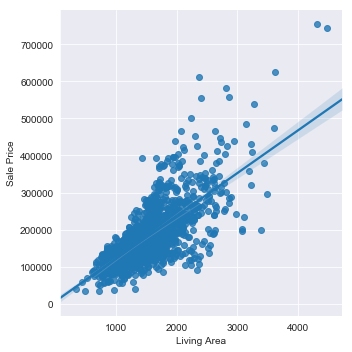

In [4]:
#remove outliers - very large
train = train.drop(train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 300000)].index)
sns.lmplot(data = train, x = "GrLivArea", y = "SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Living Area")

{'whiskers': [<matplotlib.lines.Line2D at 0x25015991978>,
 'caps': [<matplotlib.lines.Line2D at 0x2501599a320>,
 'boxes': [<matplotlib.lines.Line2D at 0x25015991748>],
 'medians': [<matplotlib.lines.Line2D at 0x2501599ac50>],
 'fliers': [<matplotlib.lines.Line2D at 0x250159a1128>],
 'means': []}

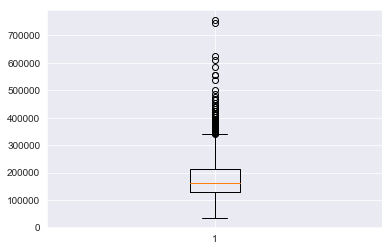

In [5]:
#now to look at saleprice
plt.boxplot(train["SalePrice"])


 mu = 180932.92 and sigma = 79467.79



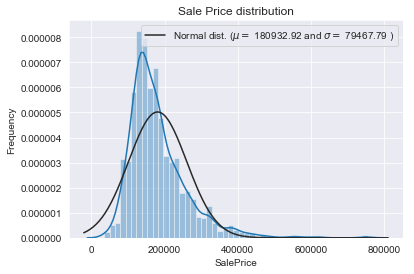

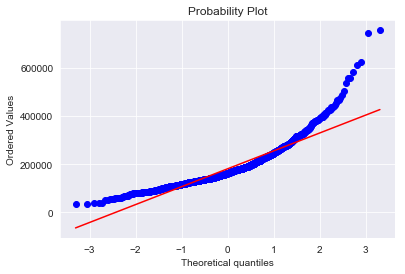

In [6]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice']) #get normal dist parameters
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best') #plot distribution details
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

fig = plt.figure() #qqplot
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() #data is heavily right skewed, can correct


 mu = 12.02 and sigma = 0.40



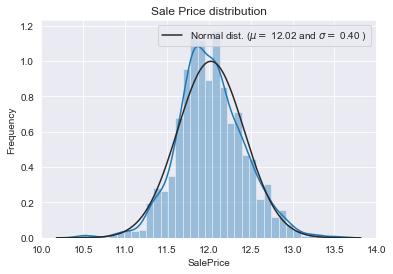

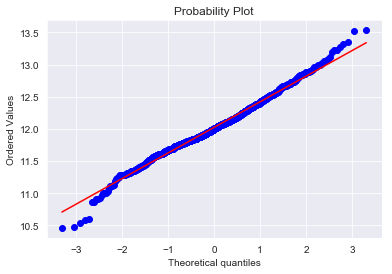

In [7]:
#apply log(1+x) to sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice']) #get normal dist parameters
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best') #plot distribution details
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

fig = plt.figure() #qqplot
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() #skew is gone

y_train = train["SalePrice"] #assign normalised y

{'whiskers': [<matplotlib.lines.Line2D at 0x25015cdc278>,
 'caps': [<matplotlib.lines.Line2D at 0x25015cdcc88>,
 'boxes': [<matplotlib.lines.Line2D at 0x25015cdc0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x25015ce35f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25015ce3a90>],
 'means': []}

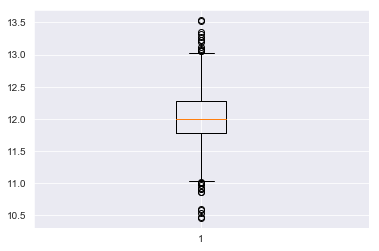

In [8]:
plt.boxplot(train["SalePrice"]) #skew has been removed

## Investigation of Predictive Features
A correlation plot was produced for 
1. The entirety of the data, including both the training and the test sets. This was produced to measure correlation between predictive features for all available data.
2. The training data alone. This was produced in order to include the SalePrice feature in the correlation plot. This is particularly informative for understanding the relationship of this variable with each predictive feature.

## Imputation of Missing Values

Currently there are missing values present in various features in the dataset. Notably, features such as PoolQC, Alley and FireplaceQu have high proportions of missing data; in most cases the feature descriptions available on the Kaggle site confirm that NA values are equivelant to 0. For example, most houses are missing the PoolQC feature as they do not have a pool. Therefore, it would be safe to replace these NA values with 0 for the purposes of our model. 

The meaning of NA values in other features was less apparent, however removal of either the feature or the columns can lead to a loss of information and a poorer final model. Instead, a suitable method of value imputation was used to predict the likely values of the missing data. For instance:
- Some categorical features such as MSZoning there was one value far more common than others, so this was used to fill missing values.
- For other features a more complicated imputation was done, for example LotFrontage; the median was calculated based on the building subclass. The size of a lot should be related to building type, and this was confirmed through the use of a pivot table. This should provide better value imputation than simply imputing a single average.

In [9]:
#combine test and train
all_data = pd.concat([train.drop(["SalePrice"], axis = 1), test])

#look at na values
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000,2431.000,2917.000,2917.000,2917.000,2917.000,2917.000,2894.000,2916.000,2916.000,...,2916.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000,2917.000
mean,57.136,69.181,10139.439,6.086,5.565,1971.288,1984.248,101.734,439.015,49.616,...,472.409,93.629,47.280,23.114,2.604,16.073,2.089,50.861,6.214,2007.793
std,42.532,22.792,7807.037,1.407,1.113,30.287,20.892,178.510,444.182,169.259,...,214.621,126.533,67.119,64.263,25.197,56.202,34.561,567.595,2.713,1.315
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000
25%,20.000,59.000,7476.000,5.000,5.000,1953.000,1965.000,0.000,0.000,0.000,...,320.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2007.000
50%,50.000,68.000,9452.000,6.000,5.000,1973.000,1993.000,0.000,368.000,0.000,...,480.000,0.000,26.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000
75%,70.000,80.000,11556.000,7.000,6.000,2001.000,2004.000,164.000,733.000,0.000,...,576.000,168.000,70.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,4010.000,1526.000,...,1488.000,1424.000,742.000,1012.000,508.000,576.000,800.000,17000.000,12.000,2010.000


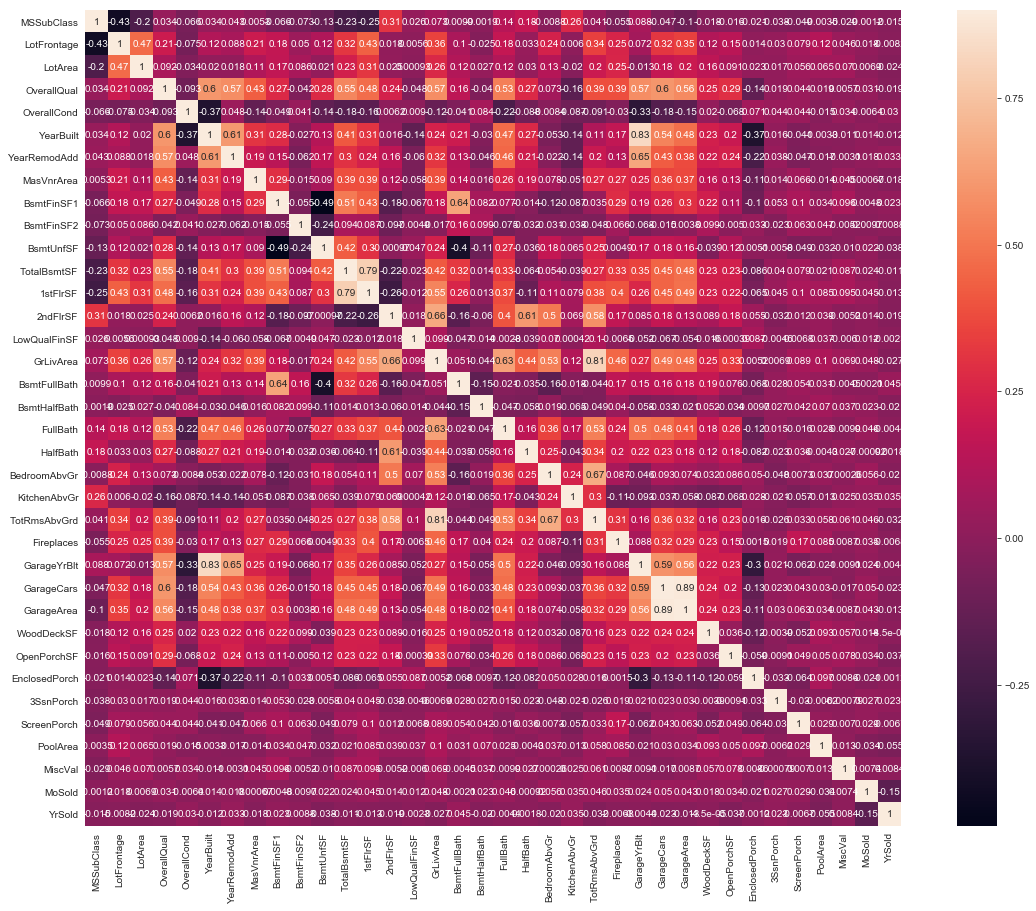

In [10]:
plt.subplots(figsize=(20,15))
sns.heatmap(all_data.corr(), vmax = 0.9, square = True, annot = True) #correlation plot for various features

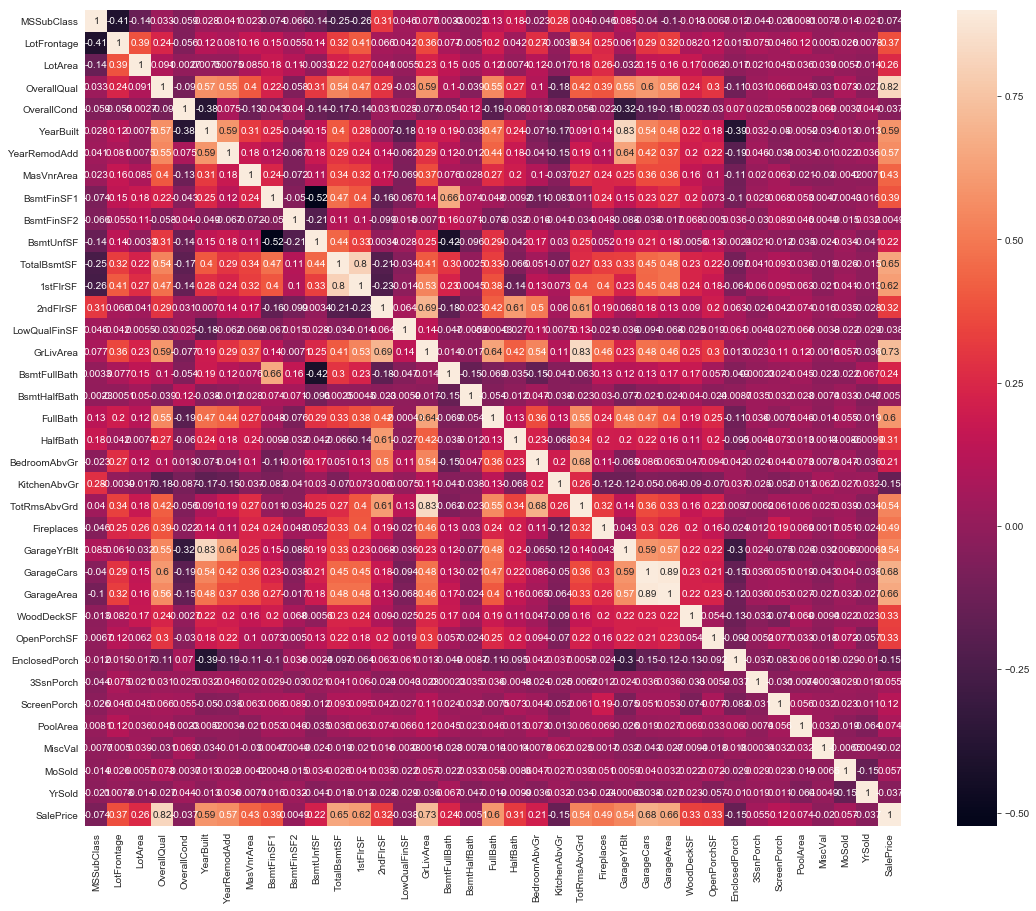

In [11]:
plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), vmax = 0.9, square = True, annot = True) #correlation plot with saleprice

In [12]:
na_ratios = all_data.isnull().sum() / len(all_data)
na_ratios = na_ratios.drop(na_ratios[na_ratios == 0].index).sort_values(ascending = False)
na_ratios = pd.DataFrame({"Missing Proportion": na_ratios})
na_ratios = na_ratios.drop(na_ratios[na_ratios["Missing Proportion"] <0.005].index)
na_ratios

,Missing Proportion
PoolQC,0.997
MiscFeature,0.964
Alley,0.932
Fence,0.804
FireplaceQu,0.487
LotFrontage,0.167
GarageFinish,0.055
GarageYrBlt,0.055
GarageQual,0.055
GarageCond,0.055


Text(0,0.5,'Missing Proportion')

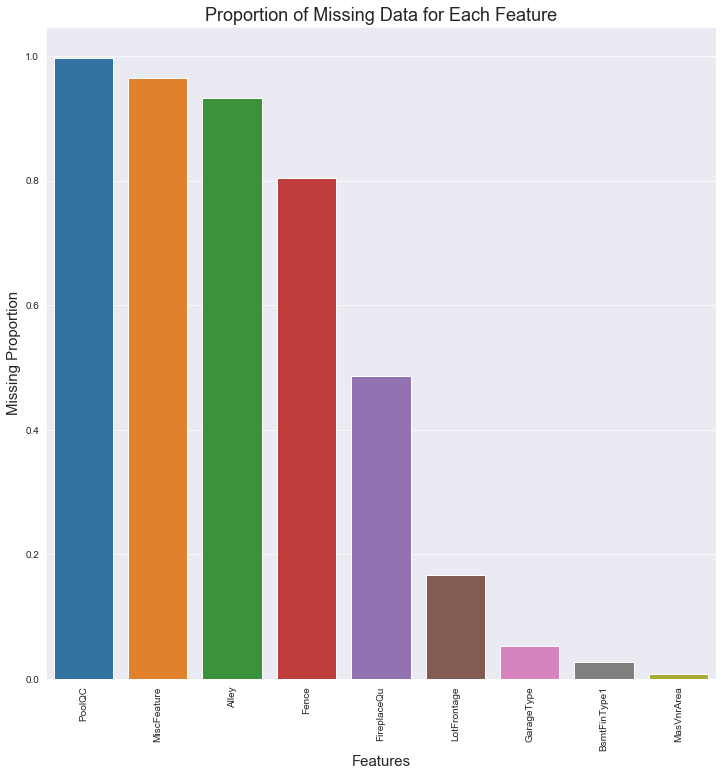

In [13]:
#the amount of missing data for "Garage", "Bsmt" and "Mas" are each roughly the same, clearing up plot
na_ratios = na_ratios.drop(index=["GarageFinish", "GarageYrBlt", "GarageQual", "GarageCond"])
na_ratios = na_ratios.drop(index=["BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2"])
na_ratios = na_ratios.drop(index=["MasVnrType"])

plt.subplots(figsize=(12, 12))
plt.xticks(rotation = "90")
sns.barplot(x=na_ratios.index, y = na_ratios["Missing Proportion"])
plt.xlabel("Features", fontsize = 15)
plt.title("Proportion of Missing Data for Each Feature", fontsize = 18)
plt.ylabel("Missing Proportion", fontsize = 15)

In [14]:
na_ratios = all_data.isnull().sum()
na_ratios = na_ratios.drop(na_ratios[na_ratios == 0].index)
na_ratios = pd.DataFrame({"Missing Count": na_ratios})
print(na_ratios) #all missing values
na_ratios.to_csv("NA_Ticklist.csv")

              Missing Count
MSZoning                  4
LotFrontage             486
Alley                  2719
Utilities                 2
Exterior1st               1
Exterior2nd               1
MasVnrType               24
MasVnrArea               23
BsmtQual                 81
BsmtCond                 82
BsmtExposure             82
BsmtFinType1             79
BsmtFinSF1                1
BsmtFinType2             80
BsmtFinSF2                1
BsmtUnfSF                 1
TotalBsmtSF               1
Electrical                1
BsmtFullBath              2
BsmtHalfBath              2
KitchenQual               1
Functional                2
FireplaceQu            1420
GarageType              157
GarageYrBlt             159
GarageFinish            159
GarageCars                1
GarageArea                1
GarageQual              159
GarageCond              159
PoolQC                 2908
Fence                  2346
MiscFeature            2812
SaleType                  1


In [15]:
all_data["MSZoning"] = all_data["MSZoning"].fillna("RL") #fill na with most common value
all_data["MSZoning"].value_counts()

RL         2267
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [16]:
#basing the lotfrontage on the building subclass - lotfrontage related to building type
lf_est = all_data[["LotFrontage", "MSSubClass"]].pivot_table("LotFrontage", "MSSubClass", aggfunc = "median")
lf_est = lf_est.fillna(np.nanmedian(all_data["LotFrontage"]))
lf_est = pd.Series(lf_est["LotFrontage"], index = lf_est.index)
lf_est

MSSubClass
20    75.000
30    60.000
40    55.000
45    55.000
50    60.000
60    75.000
70    60.000
75    65.000
80    78.000
85    72.000
90    70.000
120   43.000
160   24.000
180   21.000
190   60.000
Name: LotFrontage, dtype: float64

In [17]:
lf_na_index = all_data["LotFrontage"][all_data["LotFrontage"].isnull()].index
lf_na_ests = all_data["MSSubClass"][lf_na_index].map(lf_est)
all_data["LotFrontage"][lf_na_index] = lf_na_ests
all_data[["LotFrontage", "MSSubClass"]].ix[lf_na_index].head() #check for correct mapping
#could also use groupby on neighbourhood and use those medians
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(np.nanmedian(all_data["LotFrontage"]))

In [18]:
#following NAs need to be convered to "none" or 0 according to data descriptions
na_means_none_features = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                         "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
                         "GarageCond", "PoolQC", "Fence", "MiscFeature"]
all_data[na_means_none_features] = all_data[na_means_none_features].fillna("None")

In [19]:
all_data["Utilities"] = all_data["Utilities"].fillna("AllPub") #fill with most common value
all_data["Utilities"].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [20]:
all_data["Exterior1st"] = all_data["Exterior1st"].fillna("VinylSd")#fill with most common value
all_data["Exterior1st"].value_counts()

VinylSd    1026
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
ImStucc       1
Name: Exterior1st, dtype: int64

In [21]:
all_data["Exterior2nd"] = all_data["Exterior2nd"].fillna("VinylSd") #fill with most common value
all_data["Exterior2nd"].value_counts()

VinylSd    1015
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [22]:
fill_feature = "MasVnrType"
all_data[fill_feature] = all_data[fill_feature].fillna("None") #missing value likely means none
all_data[fill_feature].value_counts()
fill_feature = "MasVnrArea"
all_data[fill_feature] = all_data[fill_feature].fillna(0) #as previous

In [23]:
#bsmtqual means no basement, so fill other variables appropriately
fill_feature = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath", "TotalBsmtSF"]
all_data[fill_feature] = all_data[fill_feature].fillna(0)
all_data[fill_feature].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
Id,,,,,,
1,706.000,0.000,150.000,1.000,0.000,856.000
2,978.000,0.000,284.000,0.000,1.000,1262.000
3,486.000,0.000,434.000,1.000,0.000,920.000
4,216.000,0.000,540.000,1.000,0.000,756.000
5,655.000,0.000,490.000,1.000,0.000,1145.000


In [24]:
fill_feature = "SaleType"
all_data[fill_feature] = all_data[fill_feature].fillna("WD") #replace with most common value
all_data[fill_feature].value_counts()

WD       2526
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [25]:
fill_feature = "Electrical"
all_data[fill_feature] = all_data[fill_feature].fillna("SBrkr") #replace with most common value
all_data[fill_feature].value_counts()

SBrkr    2670
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [26]:
fill_feature = "KitchenQual"
all_data[fill_feature] = all_data[fill_feature].fillna("TA") #replace with most common value
all_data[fill_feature].value_counts()

TA    1493
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [27]:
fill_feature = "Functional"
all_data[fill_feature] = all_data[fill_feature].fillna("Typ") #replace with most common value
all_data[fill_feature].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [28]:
fill_feature = ["GarageCars", "GarageArea"]
all_data[fill_feature] = all_data[fill_feature].fillna(0) #replace with most common value
all_data[fill_feature].head()

,GarageCars,GarageArea
Id,,
1,2.000,548.000
2,2.000,460.000
3,2.000,608.000
4,3.000,642.000
5,3.000,836.000


In [29]:
#replace garageyrblt missing values based on OverallQual
garageYrMap = all_data.pivot_table("GarageYrBlt", "OverallQual")
garageYrMap = pd.Series(garageYrMap["GarageYrBlt"],
                       index = garageYrMap.index)
qual_to_garage_map = all_data["OverallQual"].map(garageYrMap)
garageYrBlt_nas = all_data["GarageYrBlt"].isnull().index
all_data["GarageYrBlt"][all_data["GarageYrBlt"].isnull()] = qual_to_garage_map[all_data["GarageYrBlt"].isnull()]
garageYrMap

OverallQual
1    1951.500
2    1944.800
3    1949.962
4    1959.184
5    1963.888
6    1973.182
7    1991.126
8    1999.742
9    2004.925
10   2003.690
Name: GarageYrBlt, dtype: float64

In [30]:
na_ratios = all_data.isnull().sum()
na_ratios = na_ratios.drop(na_ratios[na_ratios == 0].index)
na_ratios = pd.DataFrame({"Missing Count": na_ratios})
print(na_ratios) #all missing values filled

Empty DataFrame
Columns: [Missing Count]
Index: []






## Feature Processing and Engineering
Now each feature has no missing values, feature engineering and visualisation can take place before the final model is produced. We begin by grouping the numerical and ordinal features separately from unordered categorical features; this is done in preparation for one-hot encoding. After the grouping takes place, some final processing of features takes place including:
- Unordered categorical variables being encoded as strings to prevent them being treated as ordinal variables by the model
- Three features LowQualFinSF, 3SsnPorch, MiscVal and PoolArea are converted from numerical to categorical variables. Since almost all the data have 0 values for these features, the exact value of these datapoints is unlikely to contribute to predictions. The presence or absence of these features will likely contain the relevant information (e.g. presence or absence of a pool vs the quality of it).

Functions to plot each feature vs SalePrice are defined and used to process each variable and visualise their potential contributions to model predictions. Pivot tables are used for categorical variables (note: SalePrice has been log transformed).

A new feature is created, TotalSF, which is the total surface area of the property. This combines the basement, first floor and second floor features into a single predictor. This appears well correlated with saleprice and should provide insight into the total size of the property that cannot be gained from any of the constituent features. 

In [31]:
numerical_features = ['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'TotalSF'] #list of all the features that will be considered numerical or ordered categorical

unordered_cat_features = ['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition'] #list of all the features that will be considered unordered categorical - see data_description.txt

In [32]:
all_data['MSZoning'] = all_data['MSZoning'].apply(str) #encode mssubclass as categorical in preparation for onehotencoding

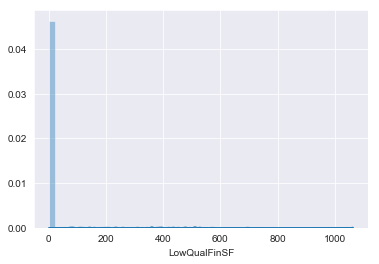

In [33]:
sns.distplot(all_data["LowQualFinSF"])
all_data["LowQualFinSF"][all_data["LowQualFinSF"] > 0] = 1
all_data["LowQualFinSF"] = all_data["LowQualFinSF"].fillna(0) #almost all of the data is at 0, so encode as categorical varialbe (0 or >0)

In [34]:
def cat_pivot(feature):
    """
    feature: a feature found in all_data
    
    returns: a pivot table based on the median value for saleprice for each category
    """
    
    ms_saleprice = pd.concat([all_data.ix[train.index][feature], y_train], axis = 1)
    return ms_saleprice.pivot_table("SalePrice", feature, aggfunc = "median").sort_values("SalePrice")

def lin_plot(feature):
    """
    feature: a feature found in all_data
    
    returns: a seaborn lmplot to assess the correlation of a variable with sale price
    """
        
    lf_saleprice = pd.concat([all_data.ix[train.index][feature], y_train], axis = 1)
    return sns.lmplot(data = lf_saleprice, x = feature, y = "SalePrice") 

In [35]:
cat_pivot("LowQualFinSF")

,SalePrice
LowQualFinSF,
1,11.787
0,12.007


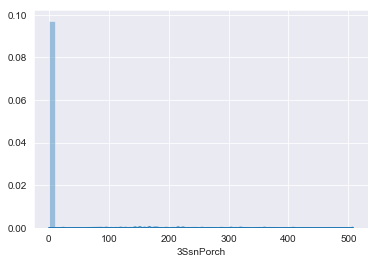

In [36]:
sns.distplot(all_data["3SsnPorch"])
all_data["3SsnPorch"][all_data["3SsnPorch"] > 0] = 1
all_data["3SsnPorch"] = all_data["3SsnPorch"].fillna(0) #almost all of the data is at 0, so encode as categorical varialbe (0 or >0)

In [37]:
cat_pivot("3SsnPorch")

,SalePrice
3SsnPorch,
0,11.995
1,12.141


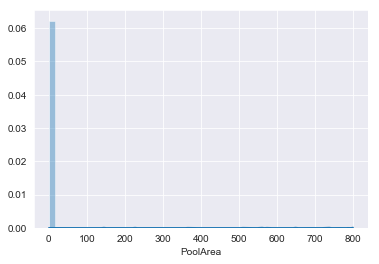

In [38]:
sns.distplot(all_data["PoolArea"])
all_data["PoolArea"][all_data["PoolArea"] > 0] = 1
all_data["PoolArea"] = all_data["PoolArea"].fillna(0) #almost all of the data is at 0, so encode as categorical varialbe (0 or >0)

In [39]:
cat_pivot("PoolArea")

,SalePrice
PoolArea,
0,12.001
1,12.398


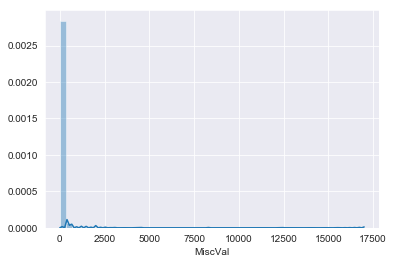

In [40]:
sns.distplot(all_data["MiscVal"])
all_data["MiscVal"][all_data["MiscVal"] > 0] = 1 #almost all of the data is at 0, so encode as categorical varialbe (0 or >0)

In [41]:
cat_pivot("MiscVal")

,SalePrice
MiscVal,
1,11.905
0,12.008


In [42]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str) #encode mssubclass as categorical

cat_pivot("MSSubClass") #demonstrating that this is a categorical variable - ordered by saleprice

,SalePrice
MSSubClass,
180,11.390
30,11.512
45,11.585
190,11.762
50,11.791
90,11.820
85,11.854
40,11.865
160,11.891


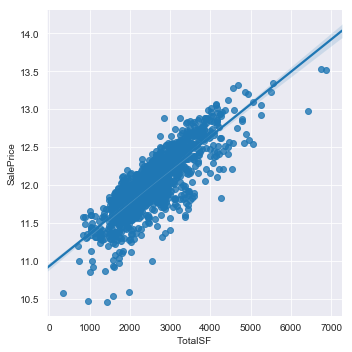

In [43]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
lin_plot("TotalSF") #create new feature - the total surface area of all floors, is well correlated with saleprice

## Checking and Correcting for Skew
From the table below it is apparent that many of the variables are heavily skewed. This leads to poor predictive performance by the final model, which assumes roughly normally distributed features, and makes data difficult to visualise. After particularly skewed features are identified, correction is performed using a Box Cox transformation. Log scaling could also be applied but led to worse predictive performance upon model testing and validation. 

LotArea, a particularly skewed variable, is visualised by a scatter plot before and after the box cox transformation to demonstrate its effect. A positive trend with SalePrice can be observed for this feature after box cox transformation, whereas previously a few houses with great LotArea accounted for a large amount of observable variation in the data.

After box cox transformation a few features appear to be particularly well correlated with SalePrice:
- TotalSF
- OverallQual
- GrLivArea
- FullBath
- TotalRmsAbvGr
- Garage Cars/Area

In [44]:
#check for skew in numerical or ordered categorical variables
skewed_features = all_data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness

,Skew
LotArea,13.109
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945
MasVnrArea,2.622
OpenPorchSF,2.529
WoodDeckSF,1.845
1stFlrSF,1.257
GrLivArea,1.069
LotFrontage,1.062


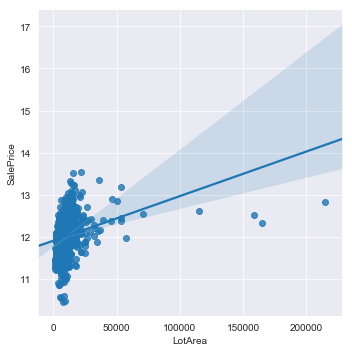

In [45]:
lin_plot("LotArea") #lot area before scaling

In [46]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features]) #can also log transform, does not appear to improve the final model      

There are 23 skewed numerical features to Box Cox transform


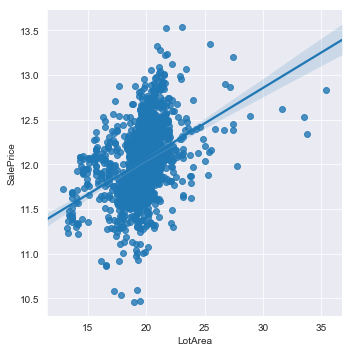

In [47]:
lin_plot("LotArea") #lot area post scaling

In [48]:
#can make plots of each variable - this code block was used for visualisation and interpretation of each feature; particularly in 
#the imputation of missing values, scaling and feature processing (ie categorical vs ordinal vs numerical)

#for feature in numerical_features:
#    lin_plot(feature)

#for feature in unordered_cat_features:
#    cat_pivot(feature)

# Model Building, Validation and Submission

## Model Pre-processing
Firstly, the previously defined unordered categorical variables are encoded using OneHotEncoder. This replaces the original categorical column by features for each category within the original feature,  filled with "1" or "0" to denote the presence or absence of the corresponding category. The first category is subsequently dropped to prevent redundancy in the data. A dataframe is created including only the features expected to be predictive of SalePrice (the unordered categorical and ordinal/numerical features defined before).

The data is once against split into a training and test set for training of the model and subsequent submission of predictions. A function is used to convert model predictions into a format accepted by Kaggle. 

In [49]:
from sklearn.preprocessing import OneHotEncoder

all_numerical_features = all_data[numerical_features]

unordCatOHE = OneHotEncoder(sparse = False, drop = "first") #use onehotencoder to deal with categorical variables
all_categorical_features = pd.DataFrame(unordCatOHE.fit_transform(all_data[unordered_cat_features]), index = all_data.index)

all_data_features = pd.concat([all_numerical_features,
                               all_categorical_features],
                               axis = 1) #create a new dataframe only containing the useful features

X_train = all_data_features.ix[train.index]
X_test = all_data_features.ix[test.index] #create new train and test datasets for use in modelling below

In [50]:
def preds_to_output(preds):
    """
    preds: predictions of saleprice for the test data
    
    returns: nothing - writes submission.csv in the same format as sample_submission.csv
    """
    output = pd.DataFrame({
        "Id": X_test.index,
        "SalePrice": preds
    })

    output.to_csv("submission.csv", index = False)
    
    print("CSV written successfully")

## Model Building
Initially a randomforestregressor model was used as a preliminary model to test the best data-preprocessing steps. This model is quick to train and so can be used to quickly assess the performance of different predictive test sets. For example this was used to determine that box cox transformation alone performed better than log scaling of predictive features. It also provided information on the most important/useful features. 5-fold cross-validation was used with mean absolute error as a scoring metric to define the success of each model.

The final model used was a gradient boosting regressor and LASSO model. Both of these models appeared to provide a better fit for the data than other techniques tested, such as the random forest method and logistic regression. The parameters of each model was tuned using the cross validation score before an average was taken of the predictions produced by each model. These were then submitted to kaggle for a score of 0.12335 (Root Mean Squared Logarithmic Error). The average of these models performed significantly better than either one alone. The feature importances show which features were most important for the final predictions, according to the gradient boost regressor. Oddly, the basement surface area appeared to perform better than total surface area, although both were crucial for the predictions produced; perhaps the presence of a basement increases the cost of a property significantly compared to one without?

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

rtree = RandomForestRegressor()
fitted_model = rtree.fit(X_train, y_train)
preds = np.expm1(rtree.predict(X_test))

def cross_val(model):
    return -np.mean(cross_val_score(model, X_train, y_train, cv = 5, scoring = "neg_mean_absolute_error"))
    
cross_val(rtree) #demonstrating cross validation method with randomforestregressor

0.1072114355806266

In [52]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 3000, #100-1000
    learning_rate = 0.005, #increase while decreasing n_trees
    max_depth = 5, #increase incrementally by 1; default 6, increasing can lead to overfit
    colsample_bytree = 0.3, # 0.3 to 0.8
    gamma = 0) #0, 1 or 5

model.fit(X_train, y_train)
cross_val(model)
xgb_preds = np.expm1(model.predict(X_test)) #store the predictions for xgbregressor
preds_to_output(xgb_preds)

CSV written successfully


In [53]:
cross_val(model)

0.08199189157776057

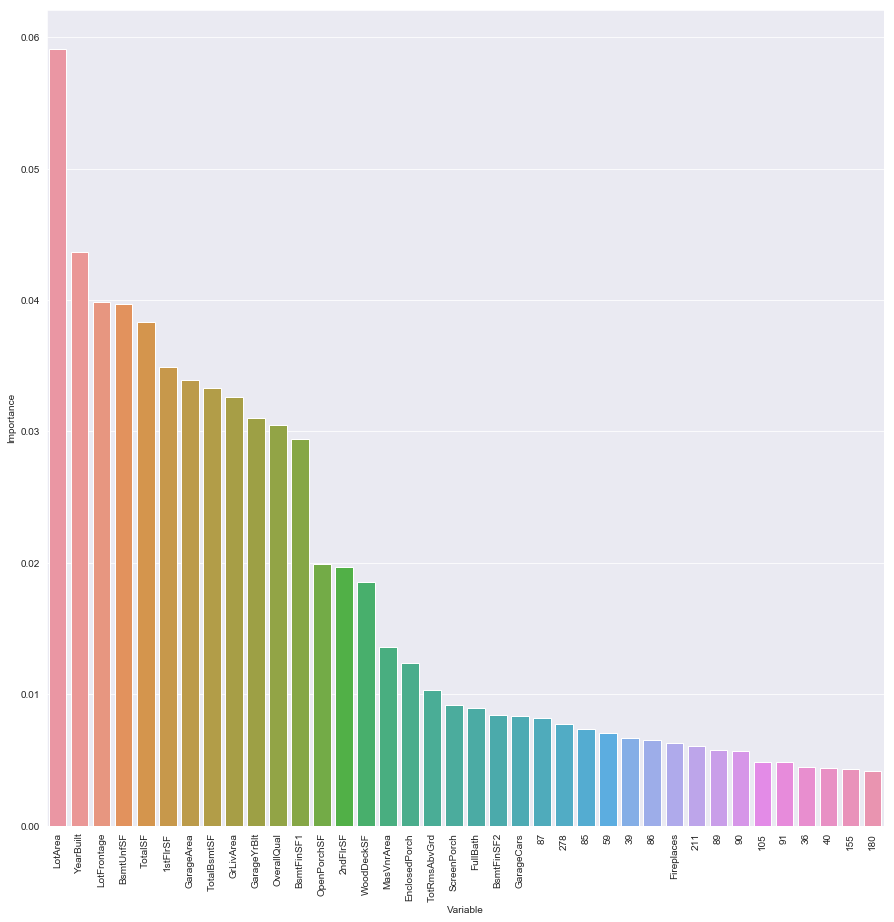

In [54]:
importances = pd.DataFrame({'Variable':X_test.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

plt.subplots(figsize=(15, 15))
plt.xticks(rotation = "90")
sns.barplot(data = importances[importances["Importance"] > 0.004], x = "Variable", y = "Importance") #plot the importance of variables according to the xgbregressor model

In [55]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler

robScale = RobustScaler()
robScaleXtrain = robScale.fit_transform(X_train)
robScaleXtest = robScale.transform(X_test)

model=Lasso(alpha = 0.00001, random_state=1)
model.fit(robScaleXtrain, y_train)

lasso_preds = np.expm1(model.predict(robScaleXtest)) #store the predictions from the lasso model
preds_to_output(lasso_preds)

CSV written successfully


In [56]:
cross_val(model)

0.08602270889729169

In [57]:
preds_to_output(((lasso_preds + xgb_preds) / 2)) #take an average of the xgbregressor and lasso models for final submission (~0.)

CSV written successfully


## Conclusion
A useful model was produced from the Ames Housing Dataset for predicting the SalesPrice of a house. The model performed well compared to other users (position 1360/4644) although there is room for improvement. To bridge the gap between the models produced above and the top performing models, a couple of further improvements should be made:
- Most importantly, I would work on understanding and implementing stacked regressions (reference: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) in place of the simple average of a LASSO model and gradient boosting regressor. 
- Many features are used to build the model, however a few features contribute far more to predictions than the rest. Further feature engineering and selection may be useful for optimising the model. Further combination of different features may lead to greater predictive power of the final model.

Further and clearer visualisation of features may also shed light on the relathionship between features and SalesPrice. The preliminary EDA performed in this notebook was surface level mainly used to understand each feature in preparation for feature processing and missing value imputation, as opposed to investigating trends within the data. 